In [1]:
from osier import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import dill
import types
from functools import partial

In [2]:
path = "../data/2023-05-30-NOBJ4-USNGA3-results.pkl"
with open(path, 'rb') as file:
    results = dill.load(file)

In [3]:
results.exec_time/3600/24

26.450016904694063

In [4]:
techs = get_tech_names(results.problem.technology_list)

In [5]:
F = results.F
slack = 0.1
F_slack = F*(1+slack)

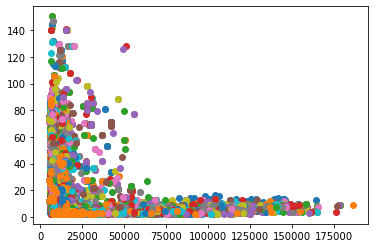

In [6]:
n_pts = 0
for i, h in enumerate(results.history):
    F_hist = h.pop.get("F")
    n_pts += len(F_hist)
    mask = F_hist < 1e40
    F_hist = np.ma.masked_values(F_hist, 1e40)
    plt.scatter(F_hist[:,0], F_hist[:,1])

In [7]:
def get_objective_names(res_obj):
    """
    This function returns a list of named objectives based on the
    names of the functions passed to Osier. In the case of partial
    functions, the first keyword value is used.
    
    Parameters
    ----------
    res_obj : :class:pymoo.Result
        The simulation results object containing all data and metadata.
    
    Returns
    -------
    obj_columns : list of str
        A list of function name strings.
    """
    obj_columns=[]
    for ofunc in res_obj.problem.objectives:
        if isinstance(ofunc, types.FunctionType):
            obj_columns.append(ofunc.__name__)
        elif isinstance(ofunc, functools.partial):
            obj_columns.append(list(ofunc.keywords.values())[0]) 
    return obj_columns

In [8]:
def moo_mga(res_obj, slack=0.1, sense='minimize'):
    """
    This function determines which individuals are 
    within the boundaries of a 'sub-optimal front'
    determined by a provided slack value.
    
    Parameters
    ----------
    res_obj : :class:pymoo.Result
        The simulation results object containing all data and metadata.
    slack : float
        The slack value for the sub-optimal front. 
    sense : str
        Indicates whether the optimization was a minimization 
        or maximization. If min, the sub-optimal front is greater
        than the Pareto front. If max, the sub-optimal front is 
        below the Pareto front.
    """
    pf = res_obj.F
    if sense.lower() == 'minimize':
        pf_slack = pf*(1+slack)
    elif sense.lower() == 'maximize':
        pf_slack = pf*(1-slack)
        
    n_objs = res_obj.problem.n_obj
    
    interior_dict = {n:[] for n in range(n_objs+1)}
    cols = get_objective_names(res_obj) + ['designs']
    
    # get list of all points
    for h in res_obj.history:
        # the history of each population, individual, 
        # and their corresponding design spaces.
        F_hist = h.pop.get("F")  # objective space
        X_hist = h.pop.get("X")  # design space
    
        for p, x in zip(F_hist, X_hist):
            # check that all coordinates of a point are within the boundaries.
            cond1 = np.any((p < pf_slack).sum(axis=1)==n_objs)
            cond2 = np.any((p > pf).sum(axis=1)==n_objs)
            if cond1 and cond2:
                for i,c in enumerate(p):
                    interior_dict[i].append(c)
                interior_dict[4].append(x)
    mga_df = pd.DataFrame(interior_dict)
    mga_df.columns = cols
    
    return mga_df

In [9]:
mdf = moo_mga(results)

In [10]:
obj_cols = get_objective_names(results)
obj_cols

['total_cost', 'lifecycle_co2_rate', 'land_use', 'percent_nonrenewable']

In [11]:
pf_obj = pd.DataFrame(dict(zip(obj_cols, F.T)))
pf_obj['optimal'] = 'Optimal'

In [12]:
pf_slack_obj = pd.DataFrame(dict(zip(obj_cols, F_slack.T)))
pf_slack_obj['optimal'] = 'Boundary'

In [13]:
mdf_obj = mdf.iloc[:,:4]
mdf_obj['optimal'] = 'Sub-opt'

In [14]:
mdf_obj_nondup = mdf_obj.drop_duplicates().reset_index(drop=True)
mdf_obj_nondup

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,optimal
0,6349.835709,21.668460,21507.513418,0.951782,Sub-opt
1,6344.245186,21.654545,21507.462122,0.952233,Sub-opt
2,5949.458670,20.005281,15416.608169,0.979554,Sub-opt
3,8309.882517,2.402467,6257.102949,0.992094,Sub-opt
4,8606.337239,2.550485,6271.208382,0.988252,Sub-opt
5,8341.828465,2.404744,6588.509200,0.988601,Sub-opt
6,5497.018807,27.930092,29295.654111,0.935974,Sub-opt
7,5520.749740,28.453851,29296.059147,0.935911,Sub-opt
8,6178.461961,13.610238,5504.969343,0.992079,Sub-opt
9,6273.116422,13.011507,5238.990823,0.974914,Sub-opt


In [15]:
combined = pd.concat([pf_obj, mdf_obj_nondup], axis=0)

In [16]:
combined.reset_index(inplace=True, drop=True)

In [17]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .1), xycoords=ax.transAxes)

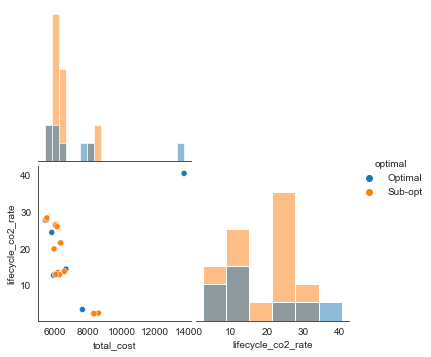

In [18]:
sb.set_style('white')
g = sb.pairplot(combined[['total_cost', 'lifecycle_co2_rate', 'optimal']], hue='optimal', diag_kind='hist', corner=True)
# g.map_lower(corrfunc)
plt.show()

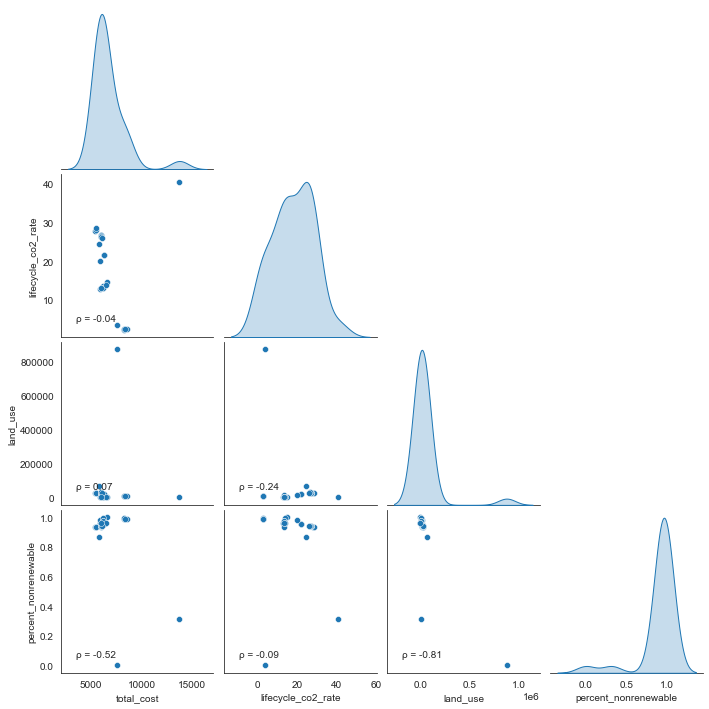

In [19]:
sb.set_style('white')
g = sb.pairplot(combined, diag_kind='kde', corner=True)
g.map_lower(corrfunc)
# g._legend.remove()
plt.show()

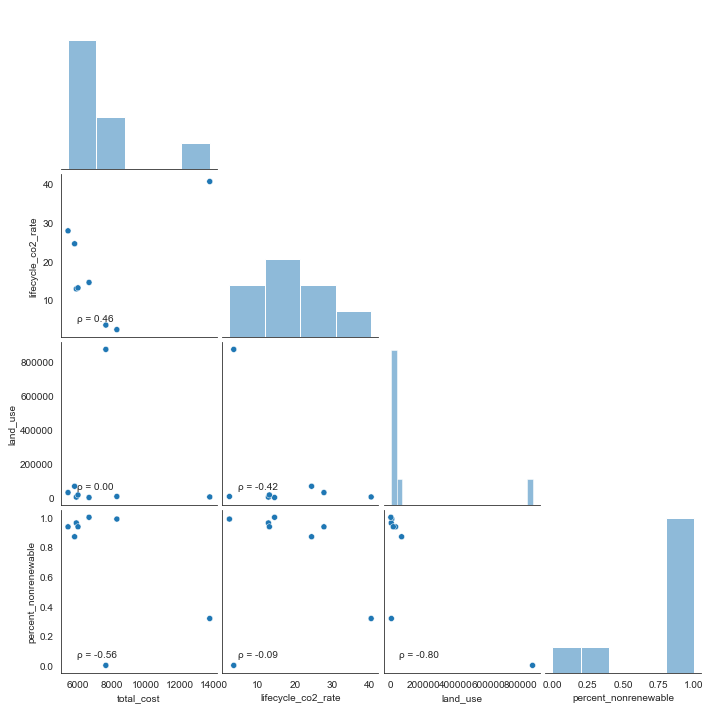

In [20]:
sb.set_style('white')
g = sb.pairplot(pf_obj, hue='optimal', diag_kind='hist', corner=True)
g.map_lower(corrfunc)
g._legend.remove()
plt.show()

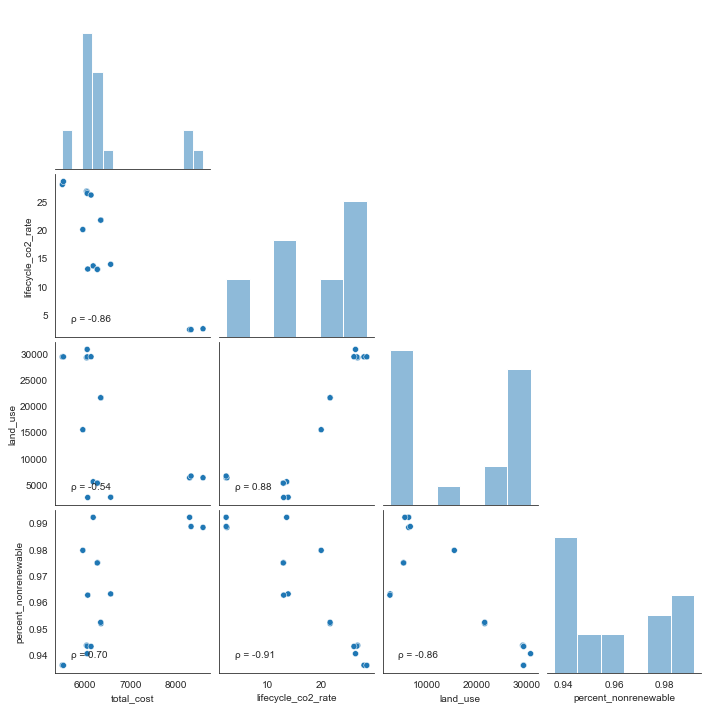

In [21]:
sb.set_style('white')
g = sb.pairplot(mdf_obj_nondup, hue='optimal', diag_kind='hist', corner=True)
g.map_lower(corrfunc)
g._legend.remove()
plt.show()

# Parallel Coordinates Plot

In [76]:
from pymoo.visualization.pcp import PCP
import matplotlib as mpl


mpl.use("pgf")
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams['text.usetex'] = True
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['figure.edgecolor'] = 'k'
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.family'] = "serif"

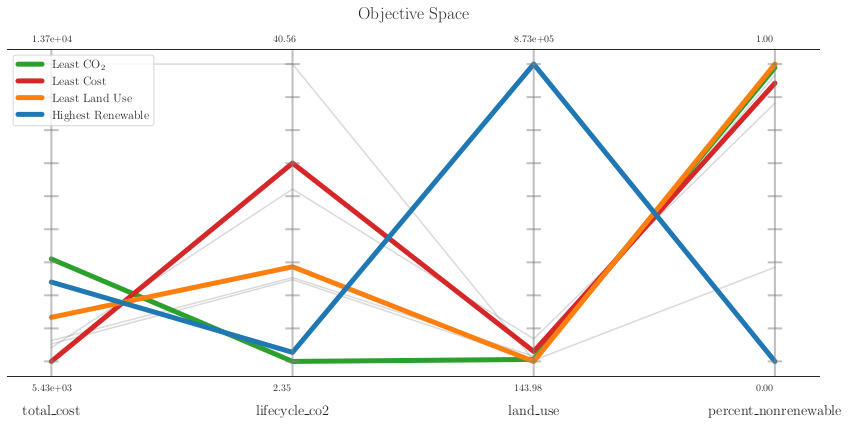

In [77]:
obj_labels = obj_cols.copy()
obj_labels[1] = 'lifecycle_co2'
plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':16}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'fontsize':12}),
           labels=obj_labels,
           figsize=(12,6),
           )

plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
plot.add(results.F, color="grey", alpha=0.3)



plot.add(results.F[0], linewidth=5, color="tab:green", label=r"Least CO$_2$")
plot.add(results.F[3], linewidth=5, color="tab:red", label="Least Cost")
plot.add(results.F[5], linewidth=5, color="tab:orange", label=r"Least Land Use")
plot.add(results.F[7], linewidth=5, color="tab:blue", label="Highest Renewable")
plot.show()
plt.savefig("C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_objective_space.pgf")

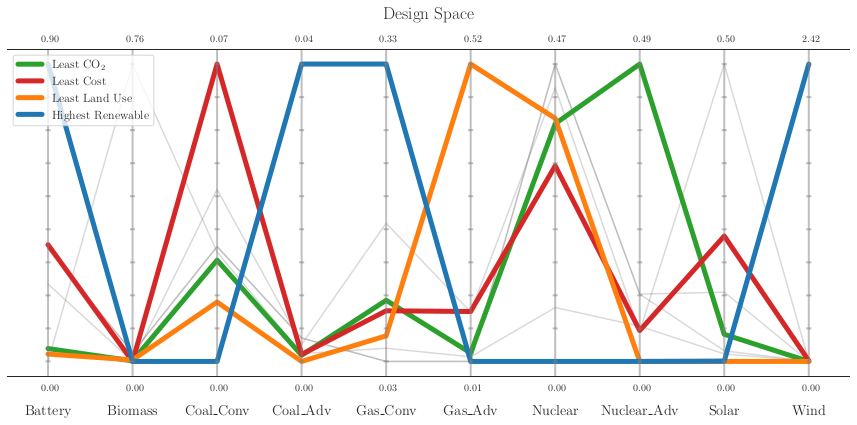

In [78]:
tech_labels = techs.copy()
tech_labels[4] = "Gas_Conv"
tech_labels[5] = "Gas_Adv"
tech_labels[-2] = "Solar"
tech_labels[-1] = "Wind"
plot = PCP(title=("Design Space", {'pad': 30, 'fontsize':16}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'fontsize':12}),
           labels=tech_labels,
           figsize=(12,6),
           )
plot.set_axis_style(color="grey", alpha=0.5)
plot.tight_layout = True
# plot.normalize_each_axis = False
plot.add(results.X, color="grey", alpha=0.3)



plot.add(results.X[0], linewidth=5, color="tab:green", label=r"Least CO$_2$")
plot.add(results.X[3], linewidth=5, color="tab:red", label="Least Cost")
plot.add(results.X[5], linewidth=5, color="tab:orange", label=r"Least Land Use")
plot.add(results.X[7], linewidth=5, color="tab:blue", label="Highest Renewable")

plot.show()
plt.savefig("C:/Users/samgd/Research/2023-dotson-prelim/docs/figures/4_obj_design_space.pgf")

In [121]:
ddf = pd.DataFrame(dict(zip(techs,results.X.T)))

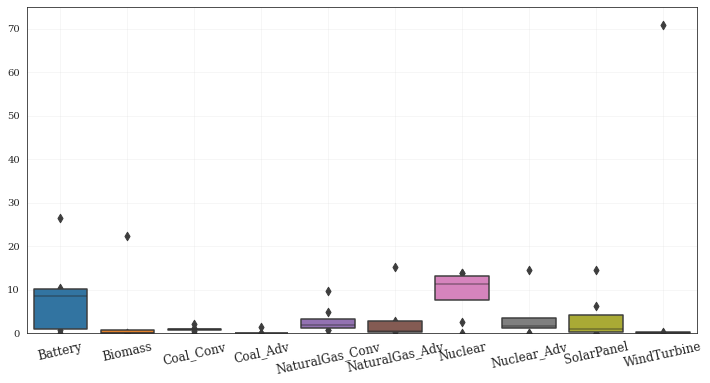

In [26]:
fig, axes = plt.subplots(1,1,figsize=(12,6), facecolor='w', sharex=True, sharey=True)
peak_demand = results.problem.max_demand
sb.boxenplot(ax=axes, data=(results.X)*peak_demand)

axes.set_xticklabels(techs, rotation=12.5, size=12)
axes.set_xticks(range(len(techs)))
# axes[2].set_ylabel("Capacity (GW)", size=14)
axes.set_xlabel("", size=14)
axes.set_ylim(0,75)

axes.grid(alpha=0.2, which='major')
axes.grid(alpha=0.05, which='minor')

In [82]:
mdf

,total_cost,lifecycle_co2_rate,land_use,percent_nonrenewable,designs
0,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
1,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
2,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
3,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
4,6349.835709,21.668460,21507.513418,0.951782,"[0.7415620704463681, 0.006974142810010853, 0.0..."
...,...,...,...,...,...
173,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."
174,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."
175,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."
176,6057.686809,13.057704,2502.319232,0.962571,"[0.34243382498061536, 0.022397843653071375, 0...."


In [103]:
designs = np.array([list(design) for design in mdf.designs.values])

In [107]:
designs_df = pd.DataFrame(dict(zip(techs,designs.T)))

In [111]:
frames = [mdf.iloc[:,:4], designs_df]
mdf_expanded = pd.concat(frames, axis=1)

In [115]:
mdf_expanded = mdf_expanded.drop_duplicates().reset_index(drop=True)

In [120]:
mdf_expanded.iloc[:,4:]

,Battery,Biomass,Coal_Conv,Coal_Adv,NaturalGas_Conv,NaturalGas_Adv,Nuclear,Nuclear_Adv,SolarPanel,WindTurbine
0,0.741562,0.006974,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
1,0.741562,0.006682,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
2,0.013693,0.015743,0.010694,0.009032,0.566365,0.033174,0.574264,0.003143,0.010036,0.038874
3,0.764091,0.000270,0.001846,0.038100,0.384120,0.073007,0.488238,0.266893,0.002902,0.015574
4,0.296661,0.000065,0.520851,0.022773,0.027388,0.038240,0.808569,0.142115,0.045845,0.000303
5,0.279696,0.005114,0.492697,0.001203,0.075734,0.158390,0.678595,0.160704,0.035962,0.004743
6,0.354288,0.000377,0.069821,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
7,0.354288,0.000593,0.072283,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
8,0.298075,0.006473,0.023906,0.002222,0.055718,0.035741,0.490168,0.137682,0.011513,0.010774
9,0.255490,0.035448,0.010025,0.003675,0.062012,0.051939,0.493553,0.100592,0.038523,0.000391


In [124]:
pd.concat([mdf_expanded.iloc[:,4:],ddf], axis=0).reset_index()

,index,Battery,Biomass,Coal_Conv,Coal_Adv,NaturalGas_Conv,NaturalGas_Adv,Nuclear,Nuclear_Adv,SolarPanel,WindTurbine
0,0,0.741562,6.974143e-03,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
1,1,0.741562,6.681875e-03,0.028396,0.040537,0.075795,0.201503,0.217118,0.022829,0.041536,0.044368
2,2,0.013693,1.574325e-02,0.010694,0.009032,0.566365,0.033174,0.574264,0.003143,0.010036,0.038874
3,3,0.764091,2.701567e-04,0.001846,0.038100,0.384120,0.073007,0.488238,0.266893,0.002902,0.015574
4,4,0.296661,6.517489e-05,0.520851,0.022773,0.027388,0.038240,0.808569,0.142115,0.045845,0.000303
5,5,0.279696,5.114035e-03,0.492697,0.001203,0.075734,0.158390,0.678595,0.160704,0.035962,0.004743
6,6,0.354288,3.773002e-04,0.069821,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
7,7,0.354288,5.925067e-04,0.072283,0.001251,0.077437,0.098358,0.312223,0.054175,0.210179,0.005858
8,8,0.298075,6.472591e-03,0.023906,0.002222,0.055718,0.035741,0.490168,0.137682,0.011513,0.010774
9,9,0.255490,3.544828e-02,0.010025,0.003675,0.062012,0.051939,0.493553,0.100592,0.038523,0.000391


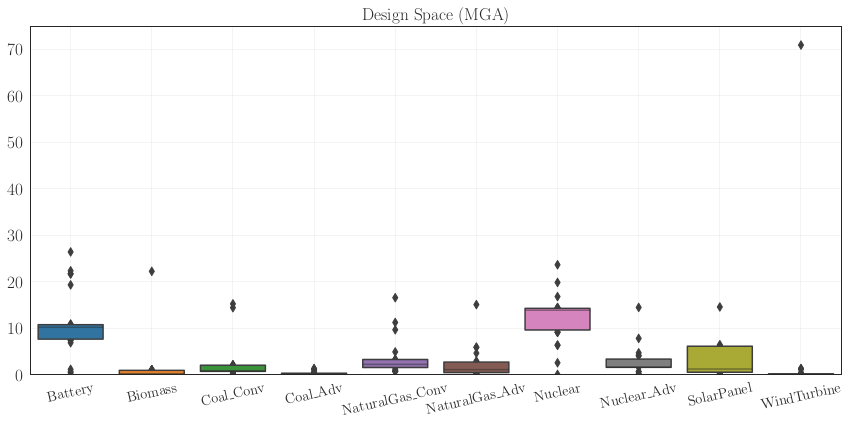

In [129]:
fig, axes = plt.subplots(1,1,figsize=(12,6), facecolor='w', sharex=True, sharey=True)
peak_demand = results.problem.max_demand
sb.boxenplot(ax=axes, 
             data=(pd.concat([mdf_expanded.iloc[:,4:],
                              ddf], 
                             axis=0).reset_index(drop=True))*peak_demand)

axes.set_xticklabels(techs, rotation=12.5, size=14)
axes.set_xticks(range(len(techs)))
# axes[2].set_ylabel("Capacity (GW)", size=14)
axes.set_xlabel("", size=14)
axes.set_ylim(0,75)

axes.grid(alpha=0.2, which='major')
axes.grid(alpha=0.05, which='minor')
axes.set_title("Design Space (MGA)", fontsize=16)
plt.tight_layout()
plt.savefig("../docs/figures/results/4-obj-mga-design-space.pgf")

# Homegrown PCP